# Problem setting
* GridWorld: Find the ice cream store
* state space: $S = \{(x,y) | x \in X, y \in Y \}$
* action space: $A = \{up,down,left,right,stay  \}$
* transition: We have environment hyper-parameter $prob_{error}$.
    * Deterministic: transition probability is 1 if the next state is valid, otherwise, stay at the same state. 
    * Stochastic: transition probability is 1-$prob_{error}$ if the next_state is valid. The rest valid states share the rest probability.
* reward: if agent stay in the ice cream store, then get a reward +1, otherwise, +0 reward.


# Algorithm 

# Hyperparameters
* Env
    * X,Y grid world size
    * stores localtion, if empty, the system will random choose one spot.
    * obstacles localtion. 
    * pitfall location. 
* Policy
    * gamma 
    * Deterministic or Stochastic

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "“backend" on line 1 in
/Users/kenfuliang/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Util

In [2]:
def get_key(dic,val): 
    rt = []
    for key, value in dic.items(): 
        if val == value:
            rt.append(key)
    return rt
def visualizePolicy(gridWidth, gridHeight, policy):
    patch=[]
    #grid height/width
    gridAdjust = 0.5
    gridScale = 1
    arrowScale = .2
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    for (state, action),actionProb in policy.items():
        statex,statey = state
        optimalActionX,optimalActionY = action
        if actionProb!=0:
            draw = plt.arrow(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale, head_width=0.05*actionProb, head_length=0.1*actionProb)    
            patch.append(draw)
    return patch

# Gridworld and MDP policy

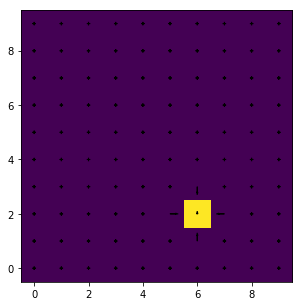

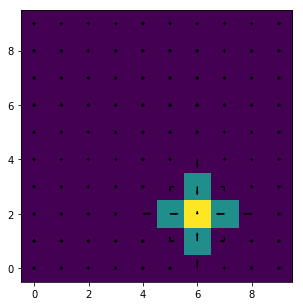

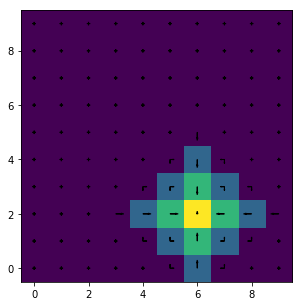

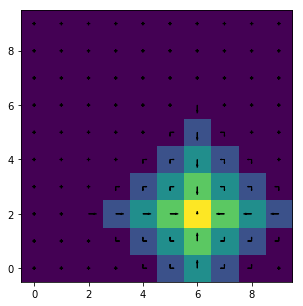

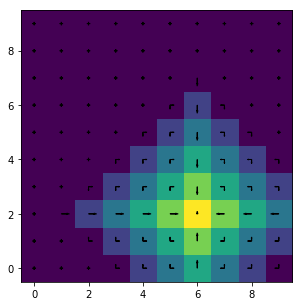

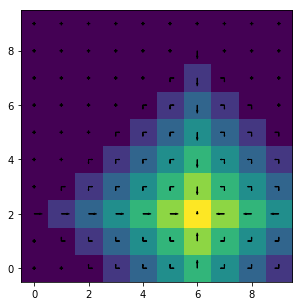

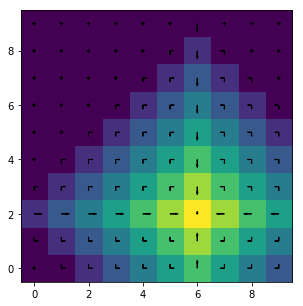

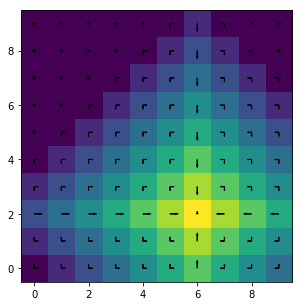

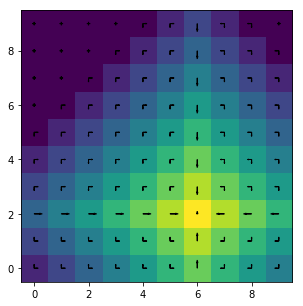

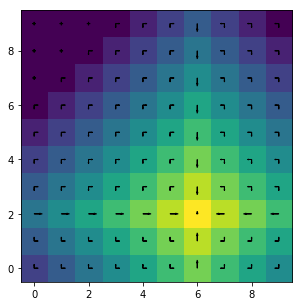

In [3]:
class GridWorld(object):
    def __init__(self,X=10,Y=10,error_prob=0,stores=[]):
        # hyperparameters 
        self.X = X
        self.Y = Y
        self.state = None
        self.error_prob = error_prob # error probability in transition matrix 
        self.stores = stores if len(stores) else [tuple(np.random.randint((1,2),(self.X,self.Y)))]
        self.obstacles = []
        self.pitfalls = []
        
        # expend to gridworld variables
        self.states = ([tuple((xx,yy)) for xx in range(self.X) for yy in range(self.Y)])
        self.actions = (tuple((0,-1)),tuple((0,1)),tuple((1,0)),tuple((-1,0)),tuple((0,0)))
        
    def transition(self,state,action):

        # init valid next_states
        rt = {}
        for a in self.actions:
            next_state = tuple(np.array(state)+np.array(a))
            if self._check_valid(next_state):
                rt[next_state]=0
        
        
        for a in self.actions:
            next_state = np.array(state)+np.array(action)
            next_state = tuple(next_state)
            if self._check_valid(next_state):
                if a == action:
                    rt[(next_state)]+=1-self.error_prob
                else:
                    rt[(next_state)]+=self.error_prob/(len(self.actions)-1)
            else: #not valid -> stay the same state
                if a == action:
                    rt[(state)]+=1-self.error_prob
                else:
                    rt[(state)]+=self.error_prob/(len(self.actions)-1) 
        rt = [(prob,state) for (state,prob) in rt.items()]
        return rt

        
    def reward(self,state,action, next_state):
        if next_state in self.stores:
            if action == tuple((0,0)):
                return 1
        return 0
        
    def _check_valid(self,next_state):
        # check valid state, return true or false
        rt = True
        if next_state[0]<0 or next_state[0]>=self.X:
            rt = rt and False
            
        if next_state[1]<0 or next_state[1]>=self.Y:
            rt = rt and False
        return rt
    
    def step(self,action):
        choice = []
        prob = []
        for (p,next_state) in self.transition(self.state,action):
            choice.append(next_state)
            prob.append(p)
        index = np.random.choice(range(len(choice)),1,p=prob)
        next_state = choice[index[0]]
        
        self.state = next_state
        reward = self.reward(state,action,next_state)
        done = next_state in self.stores
        return self.state,reward, done
        
    def SetState(self, state):
        self.state = state
            

class MDPPolicy(object):
    def __init__(self,env,gamma=0.99):
        # given
        self.env = env  
        self.gamma = gamma
        # setting
        self.deterministic = True
        
        # want
        self.value = np.zeros((self.env.X, self.env.Y))
        self.policy = {(state,action): 1/len(self.env.actions) for state in self.env.states for action in self.env.actions}
    
    def train(self):
        self.value = self.ValueIteration(self.value)
        self.policy = self.PolicyIteration(self.value)
        
        return self.value, self.policy

    def ValueIteration(self,value):
        value_pre = value.copy()
        value_next = np.zeros_like(value_pre)
        for s in self.env.states:
            Q = {a: 0 for a in self.env.actions}
            for a in self.env.actions:
                for prob, next_state in self.env.transition(s,a):
                    Q[a] += prob* ( self.env.reward(s,a,next_state) + self.gamma*value_pre[next_state] )
            value_next[s] = max(Q.values())
        return value_next       
    
    def PolicyIteration(self,value):
        # init policy 
        policy = {(s,a):None for s in self.env.states for a in self.env.actions}
        for s in self.env.states:

            Q = {a: 0 for a in self.env.actions}
            for a in self.env.actions:  
                for prob, next_state in self.env.transition(s,a):
                    Q[a]+=prob*(value[next_state])

            if self.deterministic == True:
                optimal_actions = [action for action, value in Q.items() if value==max(Q.values())]
                for a in self.env.actions:
                    if a in optimal_actions:
                        policy[(s,a)] = 1/len(optimal_actions)
                    else:
                        policy[(s,a)] = 0
            else: # softmax
                Z = sum([np.exp(a) for a in self.env.actions])
                for a in self.env.actions:
                    policy[(s,a)] = np.exp(Q[a])/Z
        return policy
    
    def predict(self, obs):
        choice = []
        prob = []
        for a in self.env.actions:
            p = self.policy[(obs,a)]
            choice.append(tuple(a))
            prob.append(p)
        index = np.random.choice(range(len(choice)),1,p=prob)[0]
        return choice[index], None
    
gridworld = GridWorld(error_prob=0)
agent = MDPPolicy(env=gridworld)


for _ in range(10):
    value,policy = agent.train()
    fig=plt.figure(figsize=(5,5))
    ax = plt.axes(xlim=(-0.5, 9.5), ylim=(-0.5, 9.5))
    plt.imshow(value.T,origin='lower',)
    visualizePolicy(10,10,policy)
    plt.show()

# Simulation from starting state until done

In [4]:
# # run simulation
state = tuple((0,0)) ## init state
gridworld.SetState(state)
traj = []
while(1):
    action, value = agent.predict(state)
    next_state, reward, done = gridworld.step(action)
    print("state:",state,"action:",action,"next_state:",next_state)
    traj.append((state,action))
    state=next_state
    if(done):
        break

state: (0, 0) action: (1, 0) next_state: (1, 0)
state: (1, 0) action: (0, 1) next_state: (1, 1)
state: (1, 1) action: (0, 1) next_state: (1, 2)
state: (1, 2) action: (1, 0) next_state: (2, 2)
state: (2, 2) action: (1, 0) next_state: (3, 2)
state: (3, 2) action: (1, 0) next_state: (4, 2)
state: (4, 2) action: (1, 0) next_state: (5, 2)
state: (5, 2) action: (1, 0) next_state: (6, 2)


### Plot Traj

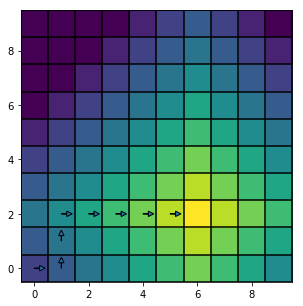

In [5]:
def PlotTraj(traj):
    fig = plt.figure(figsize=(5,5))
    gridWidth, gridHeight = 10, 10
    gridAdjust = 0.5
    gridScale = 1
    arrowScale = .2

    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    # grid lines
    for x in xs:
        draw = plt.plot([x, x], [ys[0], ys[-1]], color = "black")
    for y in ys:
        draw = plt.plot([xs[0], xs[-1]], [y, y], color = "black")

    for (state, action) in traj:
        statex,statey = state
        optimalActionX,optimalActionY = action
        draw = plt.arrow(statex, statey, optimalActionX*arrowScale, optimalActionY*arrowScale, head_width=0.2, head_length=0.2)    
    
PlotTraj(traj)
plt.imshow(agent.value.T,origin='lower')

# Animation

In [6]:
# from matplotlib import animation
# # %matplotlib qt
# fig=plt.figure(figsize=(5,5))
# ax = plt.axes(xlim=(-0.5, 9.5), ylim=(-0.5, 9.5))
# im = plt.imshow(np.zeros((10,10)))
# # initialization function: plot the background of each frame
# def init():
#     im.set_data(value_history[0])
#     return [im]

# # animation function.  This is called sequentially
# def animate(i):
#     a=value_history[i]
#     im.set_array(a)
#     im.autoscale()
#     return [im]
# anim = animation.FuncAnimation(fig, animate,
#                                frames=10, interval=100, blit=True)
# from IPython.display import HTML
# HTML(anim.to_html5_video())